# MODELOS PREDICTIVOS CON MACHINE/DEEP LEARNING

In [1]:
pip install xgboost scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 8.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 3.6 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:

# script ligero y estable para dataset grande
import os
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import joblib
from scipy import stats

RANDOM_STATE = 42
FILE_PATH = "/home/jovyan/work/data/curated/Master_Model_FinPlus.parquet"
TARGET_COL = 'NON_COMPLIANT_CONTRACT'
APPROVAL_THRESHOLD = 0.8
MODEL_OUTPUT = "xgb_model_stable.joblib"

# ---- carga ----
df = pd.read_parquet(FILE_PATH)
print("Datos cargados. Shape:", df.shape)

# ---- target ----
y = df[TARGET_COL].copy()

if y.dtype == bool:
    y = y.astype(int)
elif y.dtype == object:
    uniq = y.dropna().astype(str).str.lower().unique()
    if set(uniq).issubset({"true","t","yes","y","false","f","no","n"}):
        y = y.astype(str).str.lower().map(lambda v: 1 if v in {"true","t","yes","y"} else 0)
    else:
        # map automatico si son 2 clases
        if len(uniq) == 2:
            mapping = {uniq[0]:0, uniq[1]:1}
            y = y.astype(str).map(mapping)
        else:
            raise ValueError("TARGET no binario")
else:
    y = y.astype(int)

X = df.drop(columns=[TARGET_COL])

# ---- split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("Train/Test shapes:", X_train.shape, X_test.shape)

# ---- columnas ----
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object","bool","category"]).columns.tolist()

print("Num:", len(num_cols), "Cat:", len(cat_cols))

# ---- preprocesamiento ligero ----
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# ordinal encoder es MUCHO más ligero que onehot
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="__missing__")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer(
    [
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


# ---- modelo ----
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=1,              # MUY IMPORTANTE para que no se bloquee
    tree_method="hist",
    scale_pos_weight=scale_pos_weight
)

pipe = Pipeline([("preproc", preprocessor), ("model", xgb)])

# ---- búsqueda ligera ----
param_dist = {
    "model__n_estimators": [100, 200],
    "model__max_depth": stats.randint(3, 8),
    "model__learning_rate": [0.01, 0.03],
    "model__subsample": [0.6, 0.8],
    "model__colsample_bytree": [0.5, 0.7],
    "model__gamma": [0, 0.1]
}

rs = RandomizedSearchCV(
    pipe,
    param_dist,
    n_iter=12,            # muy reducido, estable
    cv=3,
    scoring="roc_auc",
    random_state=RANDOM_STATE,
    n_jobs=1,
    verbose=1,
    refit=True
)

print("Entrenando modelos (ligero)...")
rs.fit(X_train, y_train)

print("Mejores parámetros:", rs.best_params_)
best_pipeline = rs.best_estimator_

# ---- evaluación ----
y_prob = best_pipeline.predict_proba(X_test)[:,1]
y_pred = (y_prob >= APPROVAL_THRESHOLD).astype(int)

print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# ---- guardar ----
joblib.dump(best_pipeline, MODEL_OUTPUT)
print("Modelo guardado en:", MODEL_OUTPUT)

# ------------------ APARTADO: dataset final con nuevas columnas ------------------
# Construimos un DataFrame final con:
# - las columnas originales de X_test
# - las columnas preprocesadas (prefijo "proc_")
# - las columnas de resultado: prob_pay, approve, actual

# reset index para alinear
X_test_out = X_test.reset_index(drop=True).copy()
y_test_out = y_test.reset_index(drop=True).copy()

# transformado preprocesado (puede devolver sparse o array)
preproc = best_pipeline.named_steps["preproc"]
X_test_proc = preproc.transform(X_test_out)

# Si devuelve sparse, convertir a array
try:
    # tiene toarray?
    if hasattr(X_test_proc, "toarray"):
        X_test_proc = X_test_proc.toarray()
except Exception:
    pass

# Crear nombres de columnas procesadas (mantenemos un nombre por cada columna pasada al preprocessor)
proc_cols = []
if num_cols:
    proc_cols += [f"proc_{c}" for c in num_cols]
if cat_cols:
    proc_cols += [f"proc_{c}" for c in cat_cols]

# Asegurarnos que las dimensiones coincidan
if X_test_proc.shape[1] != len(proc_cols):
    # Caso inusual: ColumnTransformer reordena o expande columnas (no debería aquí).
    # En ese caso, sólo mostramos las primeras/últimas columnas con índices numéricos.
    proc_cols = [f"proc_{i}" for i in range(X_test_proc.shape[1])]

processed_df = pd.DataFrame(X_test_proc, columns=proc_cols)

# Resultados (probabilidades y predicciones)
results_df = pd.DataFrame({
    "prob_pay": y_prob,
    "approve": y_pred,
    "actual": y_test_out
})

# Concatenar todo en un DataFrame final
final_df = pd.concat([X_test_out.reset_index(drop=True), processed_df.reset_index(drop=True), results_df.reset_index(drop=True)], axis=1)

# Información y vista previa
print("\nDataset final (original features + preprocessed features + preds). Shape:", final_df.shape)
print("\nPrimeras 10 filas del dataset final:")
print(final_df.head(10).to_string(index=False))

# Guardar CSV para inspección
final_csv = "final_dataset_with_features_and_preds.csv"
final_df.to_csv(final_csv, index=False)
print(f"\nDataset final guardado en: {final_csv}")
# ------------------------------------------------------------------------------

print(MODEL_OUTPUT)


Datos cargados. Shape: (162977, 48)
Train/Test shapes: (130381, 47) (32596, 47)
Num: 47 Cat: 0
scale_pos_weight: 11.312871848144301
Entrenando modelos (ligero)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Mejores parámetros: {'model__colsample_bytree': 0.7, 'model__gamma': 0.1, 'model__learning_rate': 0.03, 'model__max_depth': 7, 'model__n_estimators': 200, 'model__subsample': 0.6}
AUC: 0.7547781991253913
              precision    recall  f1-score   support

           0       0.93      0.99      0.95     29949
           1       0.39      0.10      0.16      2647

    accuracy                           0.91     32596
   macro avg       0.66      0.54      0.56     32596
weighted avg       0.88      0.91      0.89     32596

[[29535   414]
 [ 2384   263]]
Modelo guardado en: xgb_model_stable.joblib

Dataset final (original features + preprocessed features + preds). Shape: (32596, 97)

Primeras 10 filas del dataset final:
 TOTAL_INCOME  AMOUNT_PRODUCT  INSTALLMENT  R

In [7]:
X_test_out = X_test.reset_index(drop=True).copy()
results = pd.DataFrame({
    "prob_pay": y_prob,
    "approve": y_pred,
    "actual": y_test.reset_index(drop=True)
})
output = pd.concat([X_test_out, results], axis=1)
output_file = "test_with_probs_simplified.csv"
output.to_csv(output_file, index=False)
print(f"\nResultados de test guardados en: {output_file}")

# 10) Guardar pipeline final (preproc + modelo)
joblib.dump(best_pipeline, MODEL_OUTPUT)
print(f"Pipeline final guardado en: {MODEL_OUTPUT}")

# 11) Top 100 imprimible
print("\nTop 100 clientes por probabilidad (test set):")
top10 = output.sort_values("prob_pay", ascending=False).head(100)
print(top10.reset_index(drop=True).to_string(index=False))


Resultados de test guardados en: test_with_probs_simplified.csv
Pipeline final guardado en: xgb_model_stable.joblib

Top 100 clientes por probabilidad (test set):
 TOTAL_INCOME  AMOUNT_PRODUCT  INSTALLMENT  REGION_SCORE  AGE_IN_YEARS  JOB_SENIORITY  HOME_SENIORITY  LAST_UPDATE  CAR_AGE  FAMILY_SIZE  REACTIVE_SCORING  PROACTIVE_SCORING  BEHAVIORAL_SCORING  DAYS_LAST_INFO_CHANGE  NUMBER_OF_PRODUCTS  DIGITAL_CLIENT  NUM_PREVIOUS_LOAN_APP  LOAN_ANNUITY_PAYMENT_SUM  LOAN_APPLICATION_AMOUNT_SUM  LOAN_CREDIT_GRANTED_SUM  NUM_STATUS_ANNULLED  NUM_STATUS_AUTHORIZED  NUM_STATUS_DENIED  NUM_STATUS_NOT_USED  NUM_FLAG_INSURED  CREDICT_CARD_BALANCE  CREDIT_CARD_LIMIT  CREDIT_CARD_PAYMENT  NUMBER_DRAWINGS_ATM  NUMBER_DRAWINGS  NUMBER_INSTALMENTS  KPI_DAYS_LAST_MOV  KPI_TOTAL_SPEND  KPI_DEBT_RATIO  KPI_LOAN_VOLATILITY  KPI_APPROVAL_RATIO  KPI_DENIAL_RATE  NAME_PRODUCT_TYPE_IDX  GENDER_IDX  EDUCATION_IDX  MARITAL_STATUS_IDX  HOME_SITUATION_IDX  OWN_INSURANCE_CAR_IDX  OCCUPATION_IDX  HOME_OWNER_IDX  EM

In [5]:
# modelo_xgb_sin_earlystopping.py
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import joblib
from scipy import stats

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- configuración ----------------
RANDOM_STATE = 42
FILE_PATH = "/home/jovyan/work/data/curated/Master_Model_FinPlus.parquet"  # ajustar si hace falta
TARGET_COL = "NON_COMPLIANT_CONTRACT"
APPROVAL_THRESHOLD = 0.8
MODEL_OUTPUT = "xgb_pipeline_no_earlystop.joblib"
# -----------------------------------------------

# ---- carga y extracción target (robusto) ----
df = pd.read_parquet(FILE_PATH)

y = df[TARGET_COL].copy()
if y.dtype == bool:
    y = y.astype(int)
elif y.dtype == object:
    vals = y.dropna().astype(str).str.lower().unique()
    if set(vals).issubset({"true","t","yes","y","false","f","no","n"}):
        y = y.astype(str).str.lower().map(lambda v: 1 if v in {"true","t","yes","y"} else 0)
    elif len(vals) == 2:
        mapping = {vals[0]: 0, vals[1]: 1}
        y = y.astype(str).map(mapping)
    else:
        raise ValueError("TARGET no binario")
else:
    y = y.astype(int)

X = df.drop(columns=[TARGET_COL])

# ---- splits: train / val / test (70/10/20) ----
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=RANDOM_STATE, stratify=y_temp
)
# (resultado: train ~70%, val ~10%, test ~20%)

# ---- columnas por tipo ----
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object","bool","category"]).columns.tolist()

# ---- preprocesador ligero ----
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="__missing__")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer(
    [("num", numeric_transformer, num_cols), ("cat", categorical_transformer, cat_cols)],
    remainder="drop",
    verbose_feature_names_out=False
)

# ---- transformar conjuntos ----
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

# nombres de features procesadas (mantenemos 1:1 aquí)
proc_feature_names = num_cols + cat_cols

# ---- cálculo de balance y modelo base ----
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist",
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False
)

# ---- RandomizedSearchCV para mejorar (sin volverse lento) ----
param_dist = {
    "n_estimators": [100, 200, 400],
    "max_depth": stats.randint(3, 9),
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.5, 0.7, 1.0],
    "gamma": [0, 0.1, 0.5],
    "min_child_weight": [1, 3, 5],
    "reg_alpha": [0, 0.01, 0.1],
    "reg_lambda": [1, 5, 10]
}

rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1,
    refit=True
)

print("Ejecutando RandomizedSearchCV...")
rs.fit(X_train_proc, y_train)
print("Mejores parámetros:", rs.best_params_)

best_model = rs.best_estimator_
# Nota: RandomizedSearchCV con refit=True ya entrena best_model sobre X_train_proc.

# ---- entrenamiento final (sin early stopping) ----
# (si quieres un re-fit explícito con los mejores parámetros, descomenta la línea siguiente)
# best_model.fit(X_train_proc, y_train)

# ---- predicción y evaluación ----
y_prob = best_model.predict_proba(X_test_proc)[:, 1]
y_pred = (y_prob >= APPROVAL_THRESHOLD).astype(int)

auc = roc_auc_score(y_test, y_prob)
print(f"AUC (ROC): {auc:.4f}")
print("\nClassification report (threshold = {:.2f}):".format(APPROVAL_THRESHOLD))
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# ---- guardar pipeline final (preprocessor + modelo) ----
final_pipeline = make_pipeline(preprocessor, best_model)
joblib.dump(final_pipeline, MODEL_OUTPUT)
print("Pipeline guardado en:", MODEL_OUTPUT)

# ------------------ Visualizaciones ------------------
# 1) Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_curve.png")
print("ROC guardada en: roc_curve.png")
plt.close()

# 2) Heatmap de correlación (sólo variables numéricas originales)
if len(num_cols) >= 2:
    corr = X_train[num_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=False, cmap="coolwarm", fmt=".2f", square=True)
    plt.title("Correlation heatmap (numeric features)")
    plt.tight_layout()
    plt.savefig("correlation_heatmap.png")
    print("Heatmap guardado en: correlation_heatmap.png")
    plt.close()

# 3) Importancia de características (top 20, según gain)
try:
    fmap = best_model.get_booster().get_score(importance_type="gain")
    importance = []
    for k, v in fmap.items():
        # k es "f0","f1",...
        idx = int(k[1:])
        name = proc_feature_names[idx] if idx < len(proc_feature_names) else f"f{idx}"
        importance.append((name, v))
    importance = sorted(importance, key=lambda x: x[1], reverse=True)[:20]
    if importance:
        names, vals = zip(*importance)
        plt.figure(figsize=(8, max(4, 0.25*len(names))))
        plt.barh(range(len(names))[::-1], vals)
        plt.yticks(range(len(names)), names[::-1])
        plt.xlabel("Gain")
        plt.title("Top feature importances (gain)")
        plt.tight_layout()
        plt.savefig("feature_importance.png")
        print("Importancia de variables guardada en: feature_importance.png")
        plt.close()
except Exception:
    # si no hay acceso a get_booster(), ignoramos
    pass

print("Proceso completado.")


Ejecutando RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores parámetros: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0.01, 'reg_lambda': 5, 'subsample': 0.8}
AUC (ROC): 0.7558

Classification report (threshold = 0.80):
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     29949
           1       0.37      0.15      0.22      2647

    accuracy                           0.91     32596
   macro avg       0.65      0.57      0.58     32596
weighted avg       0.88      0.91      0.89     32596

Confusion matrix:
 [[29246   703]
 [ 2240   407]]
Pipeline guardado en: xgb_pipeline_no_earlystop.joblib
ROC guardada en: roc_curve.png
Heatmap guardado en: correlation_heatmap.png
Importancia de variables guardada en: feature_importance.png
Proceso completado.


📁 Archivos en el directorio actual:
  - .bashrc
  - .profile
  - .bash_logout
  - xgb_model_stable.joblib
  - final_dataset_with_features_and_preds.csv
  - xgb_pipeline_no_earlystop.joblib
  - .local
  - feature_importance.png
  - correlation_heatmap.png
  - .cache
  - .npm
  - roc_curve.png
  - .ipython
  - .conda
  - .config
  - .jupyter
  - .wget-hsts
  - work

✔️ Directorio actual: /home/jovyan

📦 Cargando modelo guardado...
Modelo cargado correctamente:
 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TOTAL_INCOME',
                             

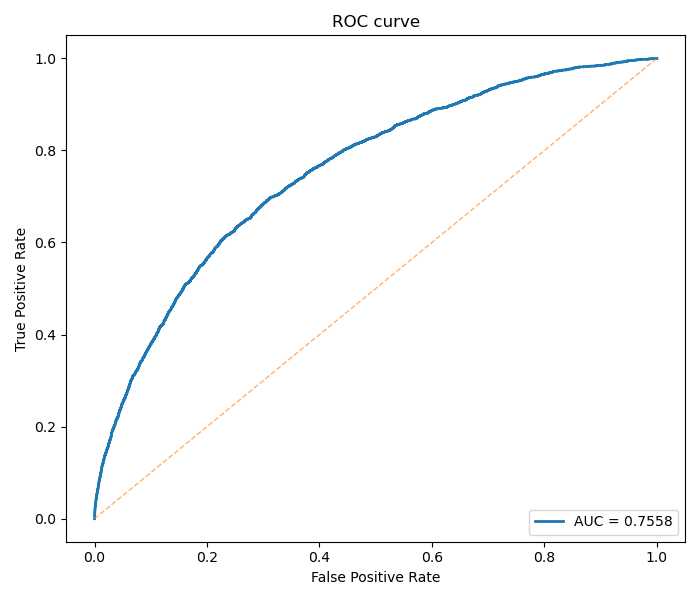


🖼️ Heatmap de correlación:


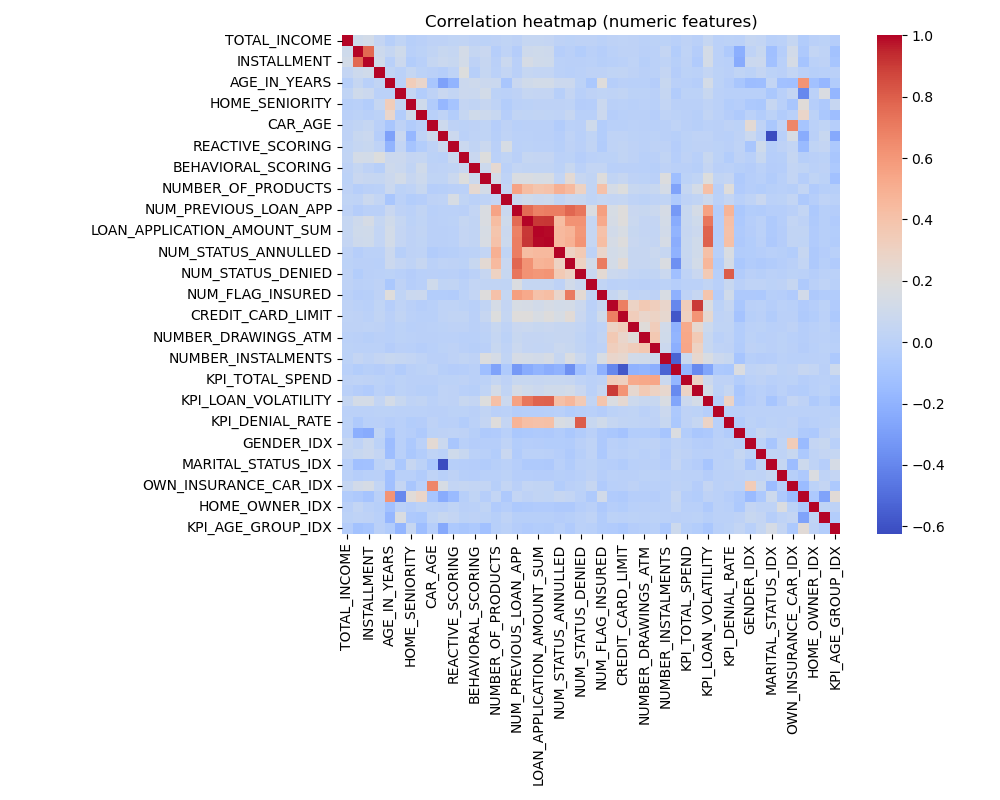


🖼️ Importancia de features:


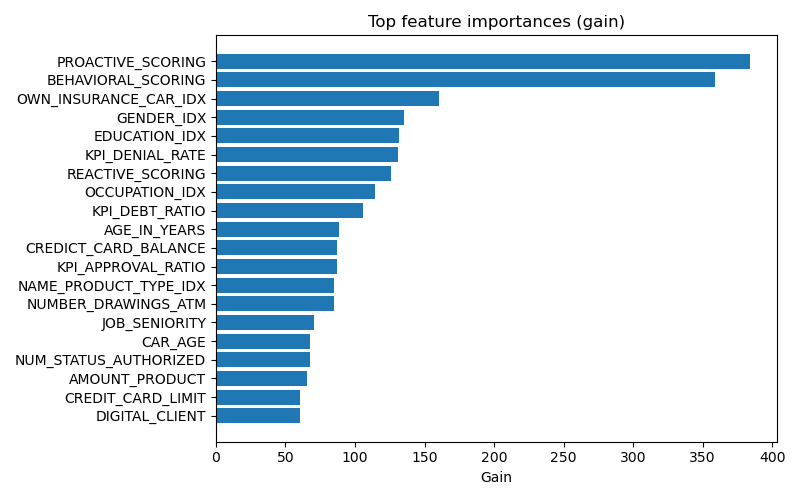


🔍 Vista previa de predicciones:


,actual,prob,pred
0,0,0.392399,0
1,0,0.377117,0
2,0,0.660890,1
3,0,0.202984,0
4,0,0.446072,0
5,0,0.044712,0
6,0,0.125867,0
7,0,0.286904,0
8,0,0.184942,0
9,0,0.239038,0


In [6]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# ----------------- CONFIG -----------------
MODEL_FILE = "xgb_pipeline_no_earlystop.joblib"
ROC_FILE = "roc_curve.png"
HEATMAP_FILE = "correlation_heatmap.png"
IMP_FILE = "feature_importance.png"
PARQUET_FILE = "/home/jovyan/work/data/curated/Master_Model_FinPlus.parquet"
TARGET_COL = "NON_COMPLIANT_CONTRACT"
# ------------------------------------------


# ==========================
# 1) Ver archivos existentes
# ==========================
print("📁 Archivos en el directorio actual:")
for f in os.listdir():
    print("  -", f)

print("\n✔️ Directorio actual:", os.getcwd())


# ==========================
# 2) Cargar modelo
# ==========================
print("\n📦 Cargando modelo guardado...")
pipeline = joblib.load(MODEL_FILE)
print("Modelo cargado correctamente:\n", pipeline)


# ==========================
# 3) Cargar dataset y predecir
# ==========================
print("\n📄 Cargando dataset...")
df = pd.read_parquet(PARQUET_FILE)
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

print("Dataset cargado. Shape:", df.shape)

print("\n🔮 Generando predicciones...")
y_prob = pipeline.predict_proba(X)[:, 1]
y_pred = pipeline.predict(X)

# ==========================
# 4) Métricas
# ==========================
print("\n📊 Métricas del modelo:")
print("AUC:", roc_auc_score(y, y_prob))
print("\nClassification Report:\n", classification_report(y, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y, y_pred))


# ==========================
# 5) Mostrar imágenes guardadas
# ==========================
def mostrar_imagen(path, titulo):
    if os.path.exists(path):
        print(f"\n🖼️ {titulo}:")
        display(Image(filename=path))
    else:
        print(f"⚠️ No se encontró {path}")

mostrar_imagen(ROC_FILE, "Curva ROC")
mostrar_imagen(HEATMAP_FILE, "Heatmap de correlación")
mostrar_imagen(IMP_FILE, "Importancia de features")


# ==========================
# 6) Vista previa de predicciones
# ==========================
print("\n🔍 Vista previa de predicciones:")
preview = pd.DataFrame({
    "actual": y,
    "prob": y_prob,
    "pred": y_pred
})
display(preview.head(10))
